In [0]:
import numpy as np 
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchsummary import summary
import matplotlib.pyplot as plt

## Sequence Generation and one hot conversion



In [0]:
def one_hot(target):
  return np.eye(101)[target]

In [0]:
X=[99]
hot_X=one_hot(X)

In [0]:
Y=[100]
hot_Y=one_hot(Y)

In [0]:
def gen_seq():
  ch=random.randint(0,1)
  A=[]
  temp=0
  for i in range(99):
    temp=random.randint(temp,98)
    A.append(temp)
  hot_A=one_hot(A)
  if ch==0:
    return (X+A+X,np.concatenate((hot_X,hot_A,hot_X), axis=0),hot_X,99) 
  return (Y+A+Y,np.concatenate((hot_Y,hot_A,hot_Y), axis=0),hot_Y,100)

## Generating 3000 test sequences

In [0]:
def gen_data(test=3000):
  data_x=[]
  data_y=[]
  for i in range(test):
    data=gen_seq()
    data_x.append(data[1])
    data_y.append(data[3])
  data_x=torch.tensor(np.array(data_x)).float()
  data_y=np.array(data_y)
  return data_x,data_y

test_x,test_y=gen_data(3000)


In [0]:
batch_size=256

# LSTM
The network contains a 3 Lstm layers of hidden size 101 and a dense layer with softmax activation.
Learning rate chosen is  $1*10^{-3}$  and RMSprop is chosen as the optimizer. The model is trained for 500 epochs and tested on 3000 samples. The loss and accuracy is averaged over 10 iteration.

In [0]:
miss_prediction=0

In [0]:
class LSTM_Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm1 = nn.LSTM(input_size=101,hidden_size=101,num_layers=3,batch_first=True)
    self.d1 = nn.Linear(101,101)
    self.a1 = nn.Softmax(dim=1)
    
  def forward(self, x):
    x,_ = self.lstm1(x)
    # print(x.shape,x[-1].shape)
    x=self.d1(x[:,-1])
    # print(x.shape)
    # print(x.shape)
    x=self.a1(x)
    return x

In [0]:
mse = nn.MSELoss(reduction="sum")
cce=nn.CrossEntropyLoss()

model = LSTM_Net()
print(model)

LSTM_Net(
  (lstm1): LSTM(101, 101, num_layers=3, batch_first=True)
  (d1): Linear(in_features=101, out_features=101, bias=True)
  (a1): Softmax(dim=1)
)


In [0]:
epochs = 100
loss_hist=np.zeros((10,epochs))
for trial in range(10):
  print("Trial :",trial)
  model = LSTM_Net()
  optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
  
  model.train()
  for i in range(epochs):
    # data_set=gen_seq()
    # seq =data_set[1]
    seq,label=gen_data(batch_size)
    label=torch.tensor(one_hot(label)).float().reshape(-1,101)
    optimizer.zero_grad()
    # seq= torch.from_numpy(seq).float().reshape(-1,101,101)
    y_pred = model(seq)
    a=y_pred.detach().numpy().reshape(1,-1)[0].reshape(-1,1)
    ind=np.argmax(a)
    # print(a[99],a[100],data_set[3],ind)
    loss = mse(y_pred,label)
    loss.backward()
    optimizer.step()
y_pred1=lstm_model(test_x)
loss = cce(y_pred,target)

    loss_hist[trial,i]=loss.item()
    if i%100==0:
      print(f'epoch: {i:3} loss: {loss.item():10.8f}')
  print(f'epoch: {i:3} loss: {loss.item():10.8f}')
  
  model.eval()
  y_pred1= model(test_x).detach().numpy()
  ind=np.argmax(y_pred1,axis=1)
  arr = ind-test_y
  a=np.where(arr != 0)
  miss_prediction+=a[0].shape[0]
  print(miss_prediction)

Trial : 0
epoch:   0 loss: 253.27818298
epoch:  99 loss: 0.16270104
0
Trial : 1
epoch:   0 loss: 253.33401489
epoch:  99 loss: 0.24887553
0
Trial : 2
epoch:   0 loss: 253.62649536
epoch:  99 loss: 0.22061351
0
Trial : 3
epoch:   0 loss: 253.28668213
epoch:  99 loss: 0.18875137
0
Trial : 4
epoch:   0 loss: 253.57086182
epoch:  99 loss: 0.53808856
0
Trial : 5
epoch:   0 loss: 254.09884644
epoch:  99 loss: 0.25431916
0
Trial : 6
epoch:   0 loss: 253.45132446
epoch:  99 loss: 0.17913353
0
Trial : 7
epoch:   0 loss: 253.72259521
epoch:  99 loss: 0.30295712
0
Trial : 8
epoch:   0 loss: 253.43991089
epoch:  99 loss: 0.21288320
0
Trial : 9
epoch:   0 loss: 253.27705383
epoch:  99 loss: 0.17279305
0


## Plot of number of sequences versus error curve.



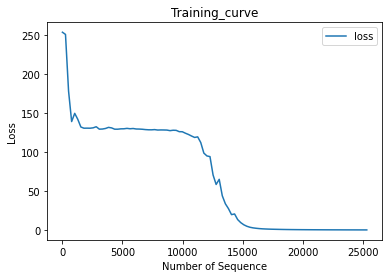

In [0]:
final_loss_hist=np.average(loss_hist,axis=0)
plt.plot(np.arange(0,batch_size*epochs,batch_size),final_loss_hist, label='loss')
plt.title('Training_curve')
plt.xlabel("Number of Sequence")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Average number of wrong predictions on the test set in 10 different trials

In [0]:
print("Average wrong prediction",miss_prediction/10)

Average wrong prediction 0.0


# RNN
The network contains a 3 RNN layers of hidden size 101 and a dense layer with softmax activation.Learning rate chosen is  $1*10^{-3}$  and RMSprop is chosen as the optimizer. The model is trained for 500 epochs and tested on 3000 samples. The loss and accuracy is averaged over 10 iteration.

In [0]:
rnn_miss_prediction=0
batch_size=128

In [0]:
class RNN_Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn1 = nn.RNN(input_size=101,hidden_size=101,num_layers=3,batch_first=True)
    self.d1 = nn.Linear(101,101)
    self.a1 = nn.Softmax(dim=1)
    
  def forward(self, x):
    x,_ = self.rnn1(x)
    # print(x.shape,x[-1].shape)
    x=self.d1(x[:,-1])
    # print(x.shape)
    # print(x.shape)
    x=self.a1(x)
    return x

In [0]:
mse = nn.MSELoss(reduction="mean")
cce=nn.CrossEntropyLoss()

rnn_model = RNN_Net()
print(rnn_model)

RNN_Net(
  (rnn1): RNN(101, 101, num_layers=3, batch_first=True)
  (d1): Linear(in_features=101, out_features=101, bias=True)
  (a1): Softmax(dim=1)
)


In [0]:
epochs = 100
rnn_loss_hist=np.zeros((10,epochs))
for trial in range(10):
  print("Trial :",trial)
  rnn_model = RNN_Net()
  rnn_optimizer = torch.optim.RMSprop(rnn_model.parameters(), lr=1e-3)
  
  rnn_model.train()
  for i in range(epochs):
    # data_set=gen_seq()
    # seq =data_set[1]
    seq,label=gen_data(batch_size)
    label=torch.tensor(one_hot(label)).float().reshape(-1,101)
    rnn_optimizer.zero_grad()
    # seq= torch.from_numpy(seq).float().reshape(-1,101,101)
    y_pred = rnn_model(seq)
    a=y_pred.detach().numpy().reshape(1,-1)[0].reshape(-1,1)
    ind=np.argmax(a)
    # print(a[99],a[100],data_set[3],ind)
    loss = mse(y_pred,label)
    loss.backward()
    rnn_optimizer.step()
    rnn_loss_hist[trial,i]=loss.item()
    if i%100==0:
      print(f'epoch: {i:3} loss: {loss.item():10.8f}')
  print(f'epoch: {i:3} loss: {loss.item():10.8f}')
  
  rnn_model.eval()
  y_pred1= rnn_model(test_x).detach().numpy()
  ind=np.argmax(y_pred1,axis=1)
  arr = ind-test_y
  a=np.where(arr != 0)
  rnn_miss_prediction+=a[0].shape[0]
  print(a[0].shape[0])

Trial : 0
epoch:   0 loss: 0.00980634
epoch:  99 loss: 0.00009734
0
Trial : 1
epoch:   0 loss: 0.00980126
epoch:  99 loss: 0.00000595
0
Trial : 2
epoch:   0 loss: 0.00980179
epoch:  99 loss: 0.01000039
3000
Trial : 3
epoch:   0 loss: 0.00979950
epoch:  99 loss: 0.00000595
0
Trial : 4
epoch:   0 loss: 0.00982787
epoch:  99 loss: 0.01000105
3000
Trial : 5
epoch:   0 loss: 0.00978829
epoch:  99 loss: 0.00001498
0
Trial : 6
epoch:   0 loss: 0.00980990
epoch:  99 loss: 0.01000069
3000
Trial : 7
epoch:   0 loss: 0.00982508
epoch:  99 loss: 0.00000630
0
Trial : 8
epoch:   0 loss: 0.00977938
epoch:  99 loss: 0.00000790
0
Trial : 9
epoch:   0 loss: 0.00981198
epoch:  99 loss: 0.00000995
0


## Plot of number of sequences versus error curve.



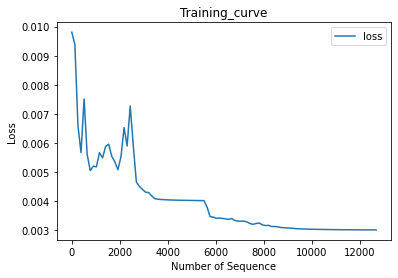

In [0]:
final_rnn_loss_hist=np.average(rnn_loss_hist,axis=0)
plt.plot(np.arange(0,batch_size*epochs,batch_size),final_rnn_loss_hist, label='loss')
plt.title('Training_curve')
plt.xlabel("Number of Sequence")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Average number of wrong predictions on the test set in 10 different trials

In [0]:
print("Average wrong prediction",rnn_miss_prediction/10)

Average wrong prediction 900.0


### Observation
- We observe that Lstm effectively predict the next character of the sequence perfectly without miss. While RNN also able to learn the correct label but its accuracy is less as compared to LSTM. We also see that at the end of number of sequence vs loss curve is smoother for LSTM as compared to RNN. 